In [2]:
!pip install spuco torch torchvision scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=34910cfa42a92bfa6cd659d17ad34190dd6407e93edd981ed32ea55510dd2057
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from torchvision import transforms

# SpuCo imports
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.utils import set_seed

set_seed(12345) # Just to get reproducible results everytime like in the hw

In [ ]:
from spuco.models import model_factory
from spuco.utils import Trainer
from torch.optim import Adam
from torch.optim import SGD
import torch.nn.functional as F

# This is the "dumb" agent that picks up on spurious features quick, if my hypotehsis is correct.
class FullModel(nn.Module):
    def __init__(self, num_classes=5):
        super(SmallBiasedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_input_dim = 32 * 7 * 7

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits


# This one has an 8x8 input, specifically for MNIST because the images are tiny there.
class SmallBiasedMNISTModel(nn.Module):
    def __init__(self, num_classes=5):
        super(SmallBiasedMNISTModel, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),


            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


        self.fc_input_dim = 32 * 2 * 2

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

class SmallerBiasedMNISTModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Input: (3, 4, 4)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1) 

        self.fc = nn.Linear(16 * 4 * 4, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x))  
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x

In [ ]:
def train_bias_model(model, loader, device, epochs=5):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"Training bias model for {epochs} epochs")
    for epoch in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

In [6]:
def get_logits_and_cluster(model, dataset, device, n_clusters):
    """
    1. Runs inference to get logits.
    2. Clusters logits using K-Means.
    3. Returns the balanced indices.
    """
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    model.eval()
    all_logits = []

    print("Extracting logits from bias model...")
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_logits.append(outputs.cpu().numpy())

    logits = np.concatenate(all_logits, axis=0)

    # Clustering
    print(f"Clustering logits into {n_clusters} groups...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(logits)

    # Balancing
    cluster_counts = Counter(cluster_labels)
    min_size = min(cluster_counts.values())
    print(f"Cluster counts: {cluster_counts}")
    print(f"Balancing to smallest cluster size: {min_size}")

    for cluster_id in range(n_clusters):
      indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
      sample_indices = np.random.choice(indices_in_cluster, 7, replace=False)

      fig, axes = plt.subplots(1, 7, figsize=(6, 2))
      for i, idx in enumerate(sample_indices):
          img, _ = dataset[idx]
          img = img.permute(1, 2, 0) if img.ndim == 3 else img  # you get some grayscale in birds
          axes[i].imshow(img.squeeze(), cmap='gray' if img.ndim == 2 else None)
          axes[i].axis('off')
          #axes[i].set_title(f"Idx {idx}")
      plt.suptitle(f"Cluster {cluster_id}")
      plt.show()

    selected_indices = []
    for cluster_id in range(n_clusters):
        # Indices in the dataset corresponding to this cluster
        indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
        # Randomly sample min_size
        selected = np.random.choice(indices_in_cluster, min_size, replace=False)
        selected_indices.extend(selected)

    return selected_indices

In [ ]:
from spuco.robust_train import ERM
device = "cuda" if torch.cuda.is_available() else "cpu"

Classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
num_classes = len(Classes) # Should be 5
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_SMALL
correlation_strength = 0.995

# ---------------------------------------------------------
# STEP 1: Setup Bias Data (Low Resolution 8x8)
# ---------------------------------------------------------
# We define a specific transform to force the model to look at color/magnitude
low_res_size = 4
low_res_transform = transforms.Compose([
    transforms.Resize((low_res_size, low_res_size), interpolation=transforms.InterpolationMode.NEAREST)
])

bias_trainset = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
    transform=low_res_transform
)
bias_trainset.initialize()


final_trainset = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
)
final_trainset.initialize()

final_trainset_selector = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
    transform=low_res_transform
)
final_trainset_selector.initialize()


Initializing Bias Dataset (8x8 Res)...


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 585kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]


Initializing Final Dataset (Standard Res)...


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

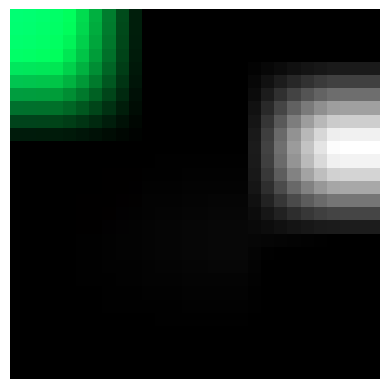

In [8]:
# VERY IMPORTANT !!!!!!!
# Check this to make sure that the model didn't "cheat" by removing the colored corner boxes.
# If you don't transform it correctly, it achieves extremely high accuracy that way.

import torchvision.transforms as T
image = T.ToPILImage()(bias_trainset[9][0]).resize((28, 28))
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis("off")

In [9]:

# ---------------------------------------------------------
# STEP 2: Train Bias Model
# ---------------------------------------------------------
bias_loader = DataLoader(bias_trainset, batch_size=64, shuffle=True)

bias_model = SmallerBiasedMNISTModel(num_classes=num_classes).to(device)
bias_model = train_bias_model(bias_model, bias_loader, device, epochs=5)

Training bias model (Resolution: Low) for 5 epochs...


In [10]:
# Small check: Did my model learn the spurious feature?

from spuco.evaluate import Evaluator

# From hw
spurious_test_ds = SpuCoMNIST(root="data/dataset",
                     spurious_feature_difficulty=difficulty,
                     classes=Classes,
                     spurious_correlation_strength=correlation_strength,
                     split="test",
                     download=True,
                     transform=low_res_transform)
spurious_test_ds.initialize()

evaluator = Evaluator(
    testset=spurious_test_ds,
    group_partition=spurious_test_ds.group_partition,
    group_weights=spurious_test_ds.group_weights,
    batch_size=64,
    model=bias_model,
    device=device,
    verbose=True
)
evaluator.evaluate()
print("\nWorst group accuracy: ", evaluator.worst_group_accuracy)
print("\nAverage accuracy:", evaluator.average_accuracy)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating group-wise accuracy:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:09,  2.42it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:09,  2.50it/s]

Group (0, 1) Accuracy: 11.11111111111111


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:09,  2.23it/s]

Group (0, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:10,  1.95it/s]

Group (0, 3) Accuracy: 5.200945626477542


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:10,  1.84it/s]

Group (0, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:03<00:10,  1.83it/s]

Group (1, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:03<00:10,  1.79it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:04<00:08,  1.94it/s]

Group (1, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:04<00:07,  2.07it/s]

Group (1, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:04<00:06,  2.17it/s]

Group (1, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:05<00:06,  2.29it/s]

Group (2, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:05<00:05,  2.35it/s]

Group (2, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:06<00:04,  2.42it/s]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:06<00:04,  2.47it/s]

Group (2, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:06<00:04,  2.47it/s]

Group (2, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:07<00:03,  2.49it/s]

Group (3, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:07<00:03,  2.47it/s]

Group (3, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:08<00:02,  2.48it/s]

Group (3, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:08<00:02,  2.50it/s]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:08<00:02,  2.47it/s]

Group (3, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:09<00:01,  2.50it/s]

Group (4, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:09<00:01,  2.49it/s]

Group (4, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:10<00:00,  2.48it/s]

Group (4, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:10<00:00,  2.50it/s]

Group (4, 3) Accuracy: 0.0


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s]

Group (4, 4) Accuracy: 100.0

Worst group accuracy:  ((0, 2), 0.0)

Average accuracy: 20.689999999999998


Extracting logits from bias model...
Clustering logits into 7 groups...
Cluster counts: Counter({np.int32(1): 9755, np.int32(3): 9439, np.int32(4): 9011, np.int32(5): 7767, np.int32(6): 5030, np.int32(2): 4642, np.int32(0): 2360})
Balancing to smallest cluster size: 2360


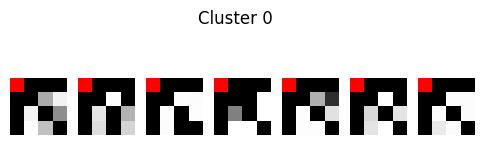

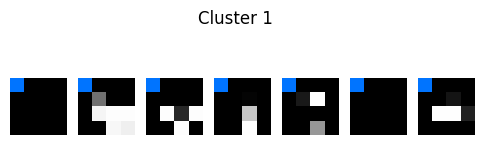

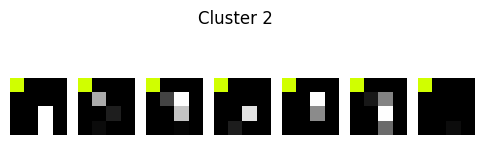

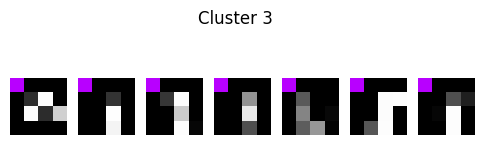

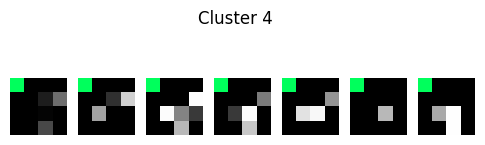

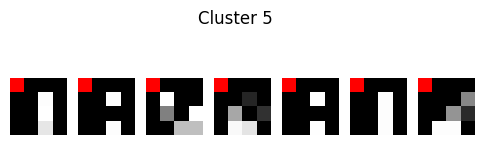

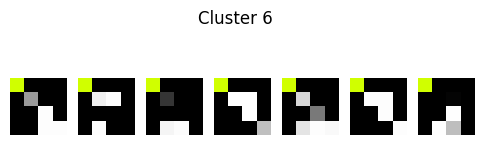

Data Selection: Kept 16520 / 48004 samples.


In [11]:

    # ---------------------------------------------------------
    # STEP 3: Cluster and Select Indices
    # ---------------------------------------------------------
    # We set n_clusters > num_classes. Since you have 5 classes,
    # let's try 15 or 20 to ensure we split "Spurious" vs "Core".
selected_indices = get_logits_and_cluster(bias_model, final_trainset_selector, device, n_clusters=7)

print(f"Data Selection: Kept {len(selected_indices)} / {len(final_trainset)} samples.")


# Create the "Clean" Subset using indices derived from the low-res model
clean_dataset = Subset(final_trainset, selected_indices)


In [12]:

input_size = final_trainset[0][0].shape
num_labels = final_trainset.num_classes
model_lenet = model_factory("lenet", input_size, num_labels).to(device)

optimizer_adam = Adam(
    model_lenet.parameters(),
    lr=1e-3
)
ermtrainer = ERM(
    trainset=clean_dataset,
    model=model_lenet,
    num_epochs=5,
    batch_size=128,
    optimizer=SGD(model_lenet.parameters(), lr=1e-2, momentum=0.9, nesterov=True),
    device=device,
    verbose=False
)

# Start training
ermtrainer.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [14]:
from spuco.evaluate import Evaluator
from random import randint


test_ds = SpuCoMNIST(root="data/dataset",
                    spurious_feature_difficulty=difficulty,
                    classes=Classes,
                    spurious_correlation_strength=correlation_strength,
                    split="test",
                    download=True,
                    transform=None)
test_ds.initialize()

evaluator = Evaluator(
    testset=test_ds,
    group_partition=test_ds.group_partition,
    group_weights=test_ds.group_weights,
    batch_size=64,
    model=model_lenet,
    device=device,
    verbose=True
)
evaluator.evaluate()
print("\nWorst group accuracy: ", evaluator.worst_group_accuracy)
print("\nAverage accuracy:", evaluator.average_accuracy)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating group-wise accuracy:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:15,  1.55it/s]

Group (0, 0) Accuracy: 99.05437352245863


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:01<00:15,  1.47it/s]

Group (0, 1) Accuracy: 96.92671394799055


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:02<00:15,  1.38it/s]

Group (0, 2) Accuracy: 98.58156028368795


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:02<00:14,  1.43it/s]

Group (0, 3) Accuracy: 98.3451536643026


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:03<00:13,  1.46it/s]

Group (0, 4) Accuracy: 99.29078014184397


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:04<00:12,  1.47it/s]

Group (1, 0) Accuracy: 98.2885085574572


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:04<00:12,  1.41it/s]

Group (1, 1) Accuracy: 99.02200488997555


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:05<00:11,  1.42it/s]

Group (1, 2) Accuracy: 98.2843137254902


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:06<00:13,  1.17it/s]

Group (1, 3) Accuracy: 98.2843137254902


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:09<00:19,  1.28s/it]

Group (1, 4) Accuracy: 98.2843137254902


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:10<00:17,  1.24s/it]

Group (2, 0) Accuracy: 97.6


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:10<00:14,  1.08s/it]

Group (2, 1) Accuracy: 96.53333333333333


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:11<00:11,  1.05it/s]

Group (2, 2) Accuracy: 99.2


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:12<00:09,  1.13it/s]

Group (2, 3) Accuracy: 99.46666666666667


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:12<00:08,  1.22it/s]

Group (2, 4) Accuracy: 98.1283422459893


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:13<00:07,  1.28it/s]

Group (3, 0) Accuracy: 95.7286432160804


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:14<00:06,  1.33it/s]

Group (3, 1) Accuracy: 94.7103274559194


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:15<00:05,  1.36it/s]

Group (3, 2) Accuracy: 94.20654911838791


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:15<00:04,  1.41it/s]

Group (3, 3) Accuracy: 95.46599496221663


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:16<00:03,  1.42it/s]

Group (3, 4) Accuracy: 93.45088161209068


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:17<00:02,  1.43it/s]

Group (4, 0) Accuracy: 88.91687657430731


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:17<00:02,  1.40it/s]

Group (4, 1) Accuracy: 89.92443324937028


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:18<00:01,  1.39it/s]

Group (4, 2) Accuracy: 93.70277078085643


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:19<00:00,  1.37it/s]

Group (4, 3) Accuracy: 90.15151515151516


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

Group (4, 4) Accuracy: 91.91919191919192

Worst group accuracy:  ((4, 0), 88.91687657430731)

Average accuracy: 96.16
